In [1]:
import pymn
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np
import itertools
import scipy.stats
import seaborn as sns
import scgen 
sc.settings.verbosity = 3   

Global seed set to 0


In [ ]:
norm_data = sc.read_h5ad('/data/passala/Collaborator_Data/Bruno_Ken_Collab/Post_review_Dataset/unintegrated_data_fast.h5ad')


In [ ]:
norm_data

In [ ]:
norm_data.var['ZM'] = norm_data.var_names.str.startswith('Zm')
norm_data = norm_data[:, norm_data.var['ZM'] == True] 
norm_data.var#

In [ ]:
norm_data.obs

In [ ]:
cell_identity = pd.read_csv('/data/passala/Collaborator_Data/Bruno_Ken_Collab/Post_review_Dataset/Meta_Maize_Sorghum_Setaria_Nuclei_Cells_SCT_OrthologousgenesGoodname_Sept2022.csv',index_col = 0)
cell_identity

In [ ]:
norm_data.obs['Cell Cluster Annotation'] = cell_identity['Annotation']
norm_data.obs['Batch'] = cell_identity['orig.ident']
norm_data.obs['Species'] = cell_identity['Species']


In [ ]:
norm_data.obs['Cluster and Type'] = norm_data.obs['Cell Cluster Annotation']
norm_data.obs['Cluster and Type'].loc[norm_data.obs_names.str.contains('Nucl')] = norm_data.obs['Cluster and Type'] + ' Nucl'
norm_data.obs['Cluster and Type'].loc[norm_data.obs_names.str.contains('Cell')] = norm_data.obs['Cluster and Type'] + ' Cell'
norm_data.obs['Cluster and Species'] = norm_data.obs['Cell Cluster Annotation']
norm_data.obs['Cluster and Species'].loc[norm_data.obs['Species'].str.contains('Maize')] = norm_data.obs['Cluster and Type'] + ' Maize'
norm_data.obs['Cluster and Species'].loc[norm_data.obs['Species'].str.contains('Millet')] = norm_data.obs['Cluster and Type'] + ' Millet'
norm_data.obs['Cluster and Species'].loc[norm_data.obs['Species'].str.contains('Sorghum')] = norm_data.obs['Cluster and Type'] + ' Sorghum'
norm_data.obs['Type'] = np.nan
norm_data.obs['Type'].loc[norm_data.obs_names.str.contains('Nucl')] = 'Nucl'
norm_data.obs['Type'].loc[norm_data.obs_names.str.contains('Cell')] = 'Cell'
norm_data.obs['Type and Species'] = norm_data.obs['Species'] + ' '+  norm_data.obs['Type']
norm_data.obs

In [ ]:
sc.pp.calculate_qc_metrics(norm_data, percent_top=None, log1p=False, inplace=True)


In [ ]:
batch_list = list(norm_data.obs['Batch'].unique())

In [ ]:
sc.pp.log1p(norm_data)

In [ ]:
sc.pp.highly_variable_genes(norm_data, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'Batch')

In [ ]:
# sc.pp.regress_out(norm_data, ['total_counts'])


In [ ]:
sc.pp.scale(norm_data, max_value=10)


In [ ]:
highly_variable_genes_across_batches  = norm_data.var['highly_variable_nbatches']>2
norm_data.var['highly_variable'].loc[highly_variable_genes_across_batches] = True


In [ ]:
high_var_list = norm_data.var.loc[highly_variable_genes_across_batches].index.to_list()


In [ ]:
norm_data.var['highly_variable_nbatches'].value_counts()

In [ ]:
sc.pl.highly_variable_genes(norm_data)

In [ ]:
sc.pl.highly_variable_genes(norm_data, show = True)

In [ ]:
sc.tl.pca(norm_data, svd_solver='arpack')
sc.pp.neighbors(norm_data, n_neighbors=10, n_pcs=40)
sc.tl.umap(norm_data)


In [ ]:
sc.tl.leiden(norm_data)


In [ ]:
sc.set_figure_params(figsize = (15,15))


In [ ]:
sc.pl.umap(norm_data, color=['Cell Cluster Annotation'], s = 12)

In [ ]:
sc.pl.umap(norm_data, color=['leiden'], s = 4)


In [ ]:
sc.pl.umap(norm_data, color=['Batch'], s = 12)

In [ ]:
sc.pl.umap(norm_data, color=['Species'], s = 12)

In [ ]:
import scgen
scgen.SCGEN.setup_anndata(norm_data, batch_key="Batch", labels_key="Cell Cluster Annotation")

model = scgen.SCGEN(norm_data)
model.train(
    max_epochs=150,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=50,
)

In [ ]:
corrected_adata = model.batch_removal()
corrected_adata

In [ ]:
#corrected_adata.write('/data/passala/Generated_Tables/Temp_junk/corrected_norm_data_from_bruno.h5ad')

In [2]:
corrected_adata = sc.read_h5ad('/data/passala/Generated_Tables/Temp_junk/corrected_norm_data_from_bruno.h5ad')

In [3]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:33)


2022-10-24 02:23:25.138536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-24 02:23:25.160243: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-24 02:23:26.005861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-24 02:23:26.005994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-24 02:23:26.006003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Ca

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:53)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


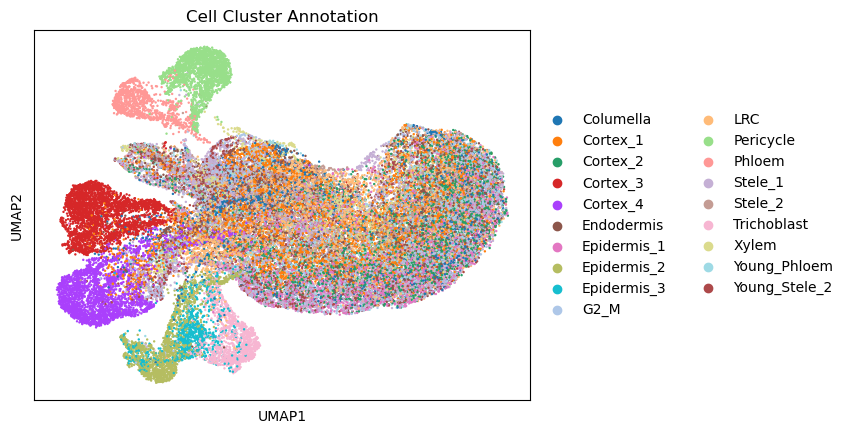

In [4]:
# sc.pl.umap(corrected_adata, color=['Cell Cluster Annotation'], s = 12)

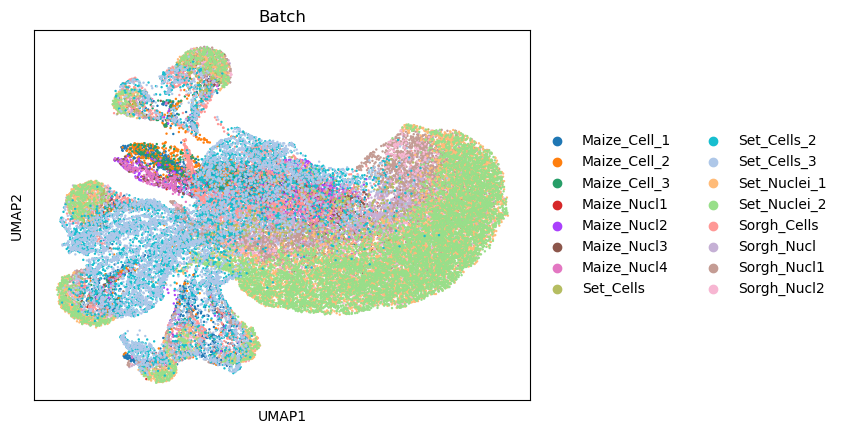

In [5]:
# sc.pl.umap(corrected_adata, color=['Batch'], s = 12)

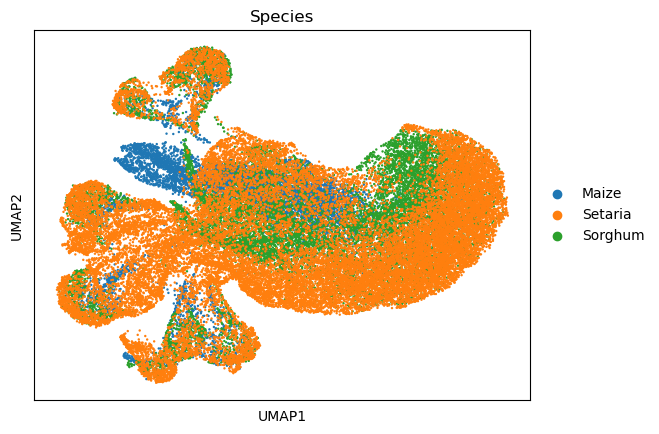

In [6]:
sc.pl.umap(corrected_adata, color=['Species'], s = 12)

/home/passala/miniconda3/envs/Single_cell_data/lib/python3.9/site-packages/seaborn/matrix.py:1221: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


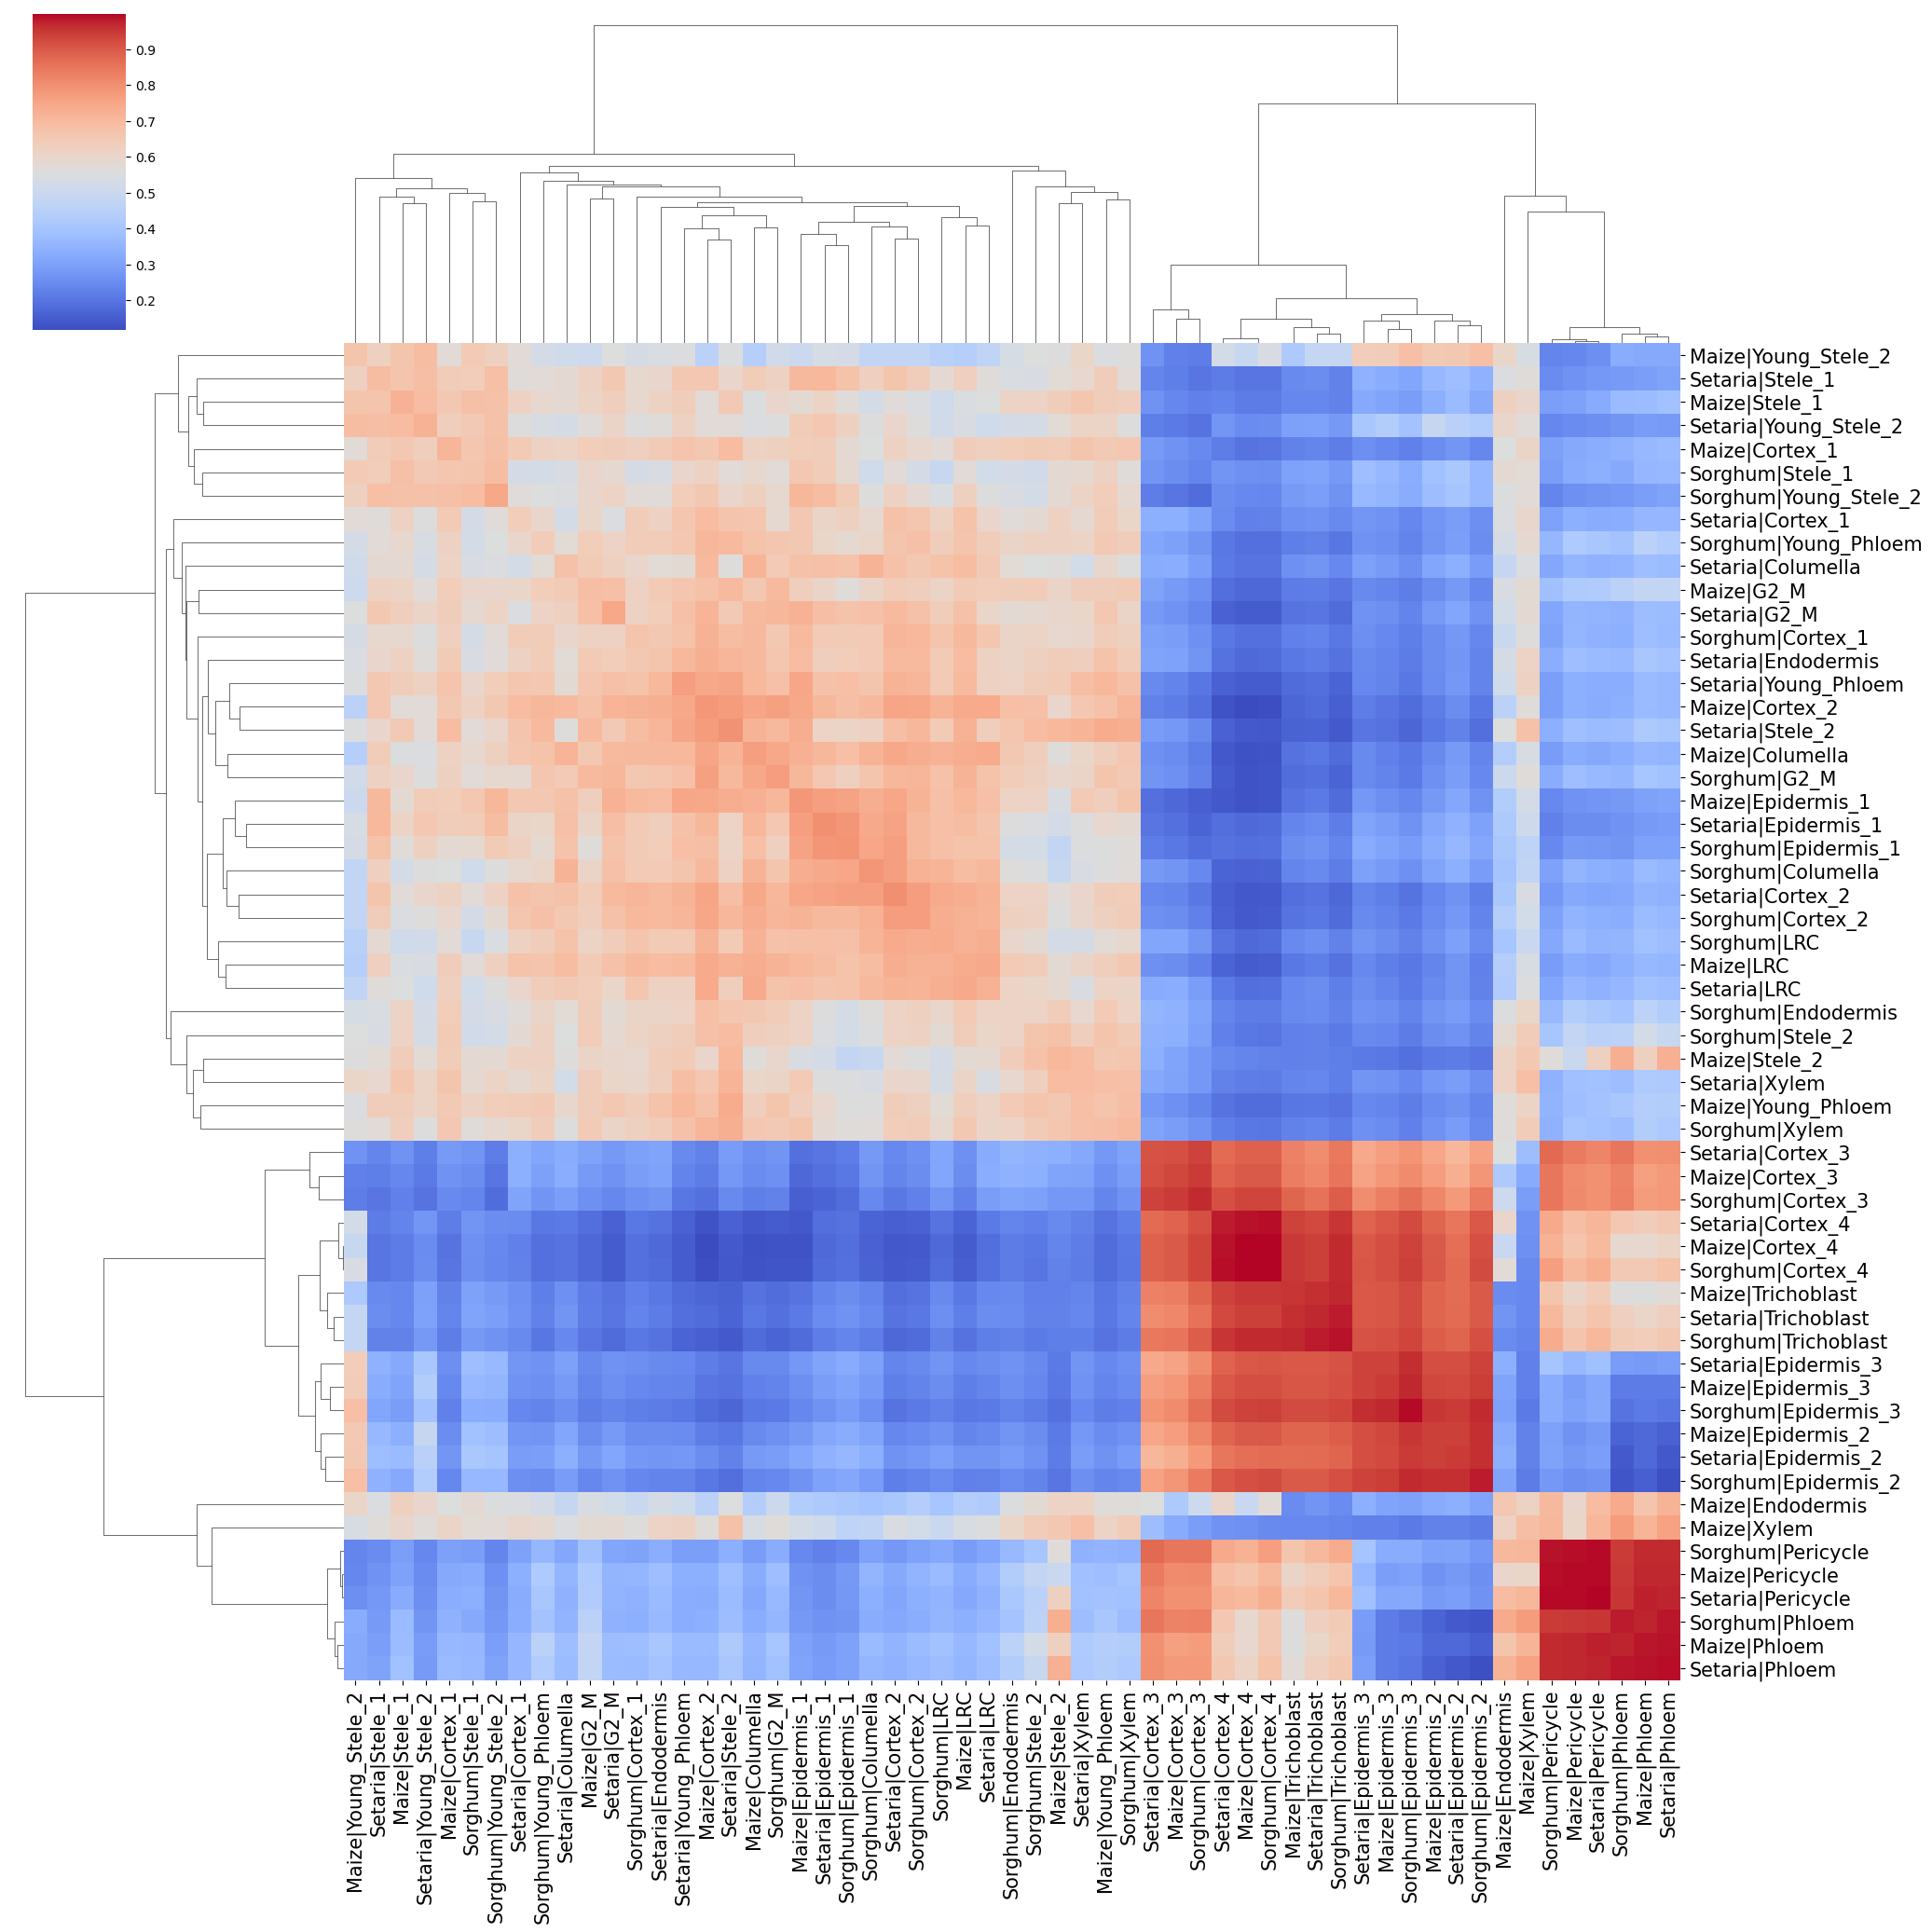

In [8]:
# pymn.variableGenes(corrected_adata,study_col = 'Species')
# pymn.MetaNeighborUS(corrected_adata,study_col = 'Species',ct_col = 'Cell Cluster Annotation', compute_p= True)
# g = pymn.plotMetaNeighborUS(corrected_adata,figsize = (20,20),fontsize = 15,show = False,cbar_pos = (0.02,0.82,0.05,0.17), cmap = 'coolwarm')
# g.savefig('/data/passala/Plots_for_projects/Bruno_Ken_cross_species_single_cell/different_integration_method_metaneighbor_redo.svg')

In [9]:
corrected_adata

AnnData object with n_obs × n_vars = 47536 × 29539
    obs: 'Cell Cluster Annotation', 'Batch', 'Species', 'Cluster and Type', 'Cluster and Species', 'Type', 'Type and Species', 'n_genes_by_counts', 'total_counts', 'leiden', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'umap', 'Cell Cluster Annotation_colors', 'Batch_colors', 'Species_colors', 'MetaNeighborUS', 'MetaNeighborUS_params', 'MetaNeighborUS_pval'
    obsm: 'corrected_latent', 'latent', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
sc.pp.neighbors(corrected_adata, use_rep="corrected_latent")
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=['Species', 'Cell Cluster Annotation'])

In [ ]:
sc.pl.umap(corrected_adata, color=['Species'], s = 12)

In [ ]:
sc.pl.umap(corrected_adata, color=['Batch'], s = 12)

In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 42

In [ ]:
sc.settings.figdir = '/data/passala/Plots_for_projects/Coexpressolog_paper_plots'

In [ ]:
sc.pl.umap(corrected_adata, color=['Cell Cluster Annotation'], s = 12)